In [2]:
# importing necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")
# import fasttext
# import string
# from string import digits
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Data Preperation :

In [3]:
# dataset consist of five rows
# each row consist of english sentence along with its french translation

train_data_corpus = [('where did you put your key ?', ' où est-ce tu as mis ta clé  ? '),
('you missed a spot .', 'tu as loupé une tache . '),
("i think we're being followed .", ' je pense que nous sommes suivis . '),
('i bought a cactus .', " j'ai acheté un cactus ."), 
('i have more than enough .', " j'en ai plus que marre . ") ]

In [4]:
# create a dataframe using list of sentences

train_data = pd.DataFrame(train_data_corpus,columns=['eng_sent','french_sent'])

In [5]:
# glimpse of dataset

train_data

,eng_sent,french_sent
0,where did you put your key ?,où est-ce tu as mis ta clé ?
1,you missed a spot .,tu as loupé une tache .
2,i think we're being followed .,je pense que nous sommes suivis .
3,i bought a cactus .,j'ai acheté un cactus .
4,i have more than enough .,j'en ai plus que marre .


### Data cleaning:

In [6]:
# # data cleaning

# # Lowercase all characters
# train_data['eng_sent']=train_data['eng_sent'].apply(lambda x: x.lower())

# train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub(r"won\'t", "will not", x))
# train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub(r"can\'t", "can not", x))

# # general
# train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub(r"n\'t", " not", x))
# train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub(r"\'re", " are", x))
# train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub(r"\'s", " is", x))
# train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub(r"\'d", " would", x))
# train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub(r"\'ll", " will", x))
# train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub(r"\'t", " not", x))
# train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub(r"\'ve", " have", x))
# train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub(r"\'m", " am", x))

# # Remove quotes
# train_data['eng_sent']=train_data['eng_sent'].apply(lambda x: re.sub("'", '', x))

train_data['eng_sent'] = train_data['eng_sent'].apply(lambda x: re.sub('[!.?]',"",x))
train_data['french_sent'] = train_data['french_sent'].apply(lambda x: re.sub('[!.?]',"",x))

In [7]:
# we specify start of sentence with '<start>'
# we specify end of sentence with '<end>'

train_data['french_sent'] = '<start> ' + train_data.french_sent 
train_data['french_sent'] = train_data.french_sent + ' <end>' 

In [8]:
# dataset after preprocessing

train_data

,eng_sent,french_sent
0,where did you put your key,<start> où est-ce tu as mis ta clé <end>
1,you missed a spot,<start> tu as loupé une tache <end>
2,i think we're being followed,<start> je pense que nous sommes suivis <end>
3,i bought a cactus,<start> j'ai acheté un cactus <end>
4,i have more than enough,<start> j'en ai plus que marre <end>


In [9]:
# Tokenization on data

token_eng = Tokenizer()
token_eng.fit_on_texts(train_data['eng_sent'].values)
token_french = Tokenizer(filters='')
token_french.fit_on_texts(train_data['french_sent'].values)

In [10]:
# have a look at words in eng vocab

token_eng.word_index

{'i': 1,
 'you': 2,
 'a': 3,
 'where': 4,
 'did': 5,
 'put': 6,
 'your': 7,
 'key': 8,
 'missed': 9,
 'spot': 10,
 'think': 11,
 "we're": 12,
 'being': 13,
 'followed': 14,
 'bought': 15,
 'cactus': 16,
 'have': 17,
 'more': 18,
 'than': 19,
 'enough': 20}

In [11]:
# vocab size for given dataset

vocab_size_eng=len(token_eng.word_index.keys())
print('Vocab size of english is',vocab_size_eng)
print("*"*100)
vocab_size_french=len(token_french.word_index.keys())
print('Vocab size of french is',vocab_size_french)

Vocab size of english is 20
****************************************************************************************************
Vocab size of french is 26


###  Data analysis :

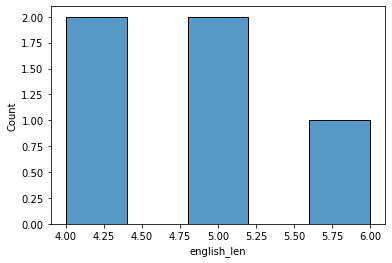

In [12]:
# lets check length of senetence

train_data['french_len'] = train_data['french_sent'].apply(lambda x: len(x.split()))
train_data['english_len'] = train_data['eng_sent'].apply(lambda x: len(x.split()))

sns.histplot(train_data.english_len, bins=5)
plt.show()

In [13]:
# we can identify the length of text in percentile
for i in np.arange(0.1,1.1,0.1):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(train_data.english_len, i)))

10 Quantile is 4.0
20 Quantile is 4.0
30 Quantile is 4.2
40 Quantile is 4.6
50 Quantile is 5.0
60 Quantile is 5.0
70 Quantile is 5.0
80 Quantile is 5.2
90 Quantile is 5.6
100 Quantile is 6.0


In [14]:
# convert text to numbers

max_len = 6

# text to sequence

train_eng = token_eng.texts_to_sequences(train_data.eng_sent)
train_french = token_french.texts_to_sequences(train_data.french_sent)

# padding


train_eng_seq = pad_sequences(train_eng, maxlen=max_len, padding='post', dtype='int32')
train_french_seq = pad_sequences(train_french, maxlen=max_len, padding='post', dtype='int32')

#convert it to tensor 
src_data = torch.tensor(train_eng_seq).to(torch.int64)
tgt_data = torch.tensor(train_french_seq).to(torch.int64)

## Transformer model :

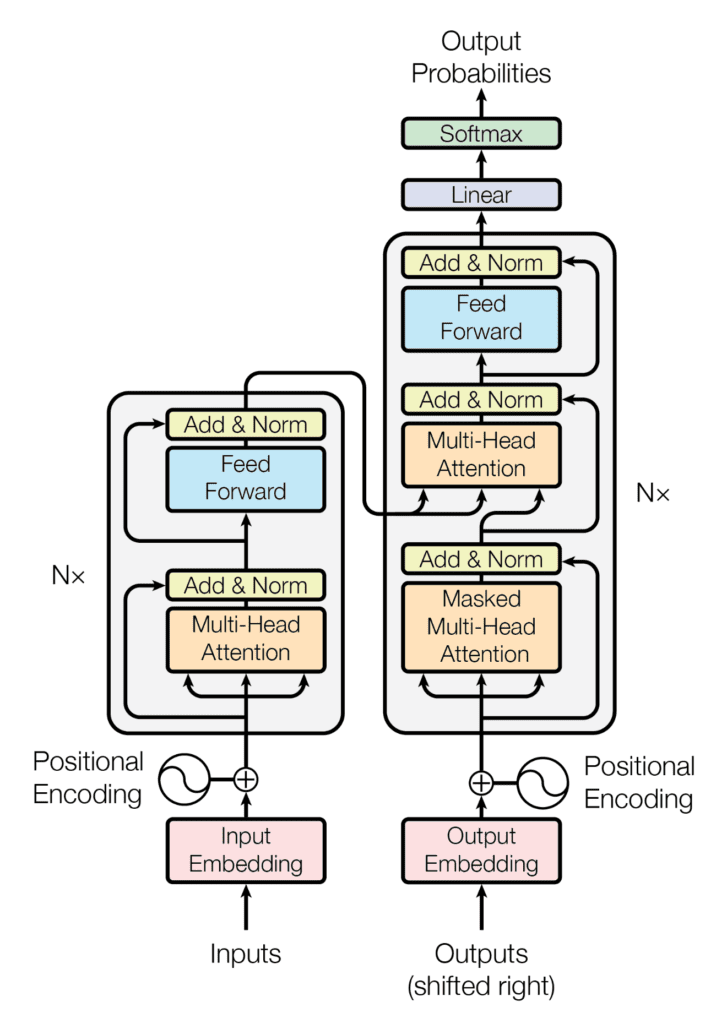

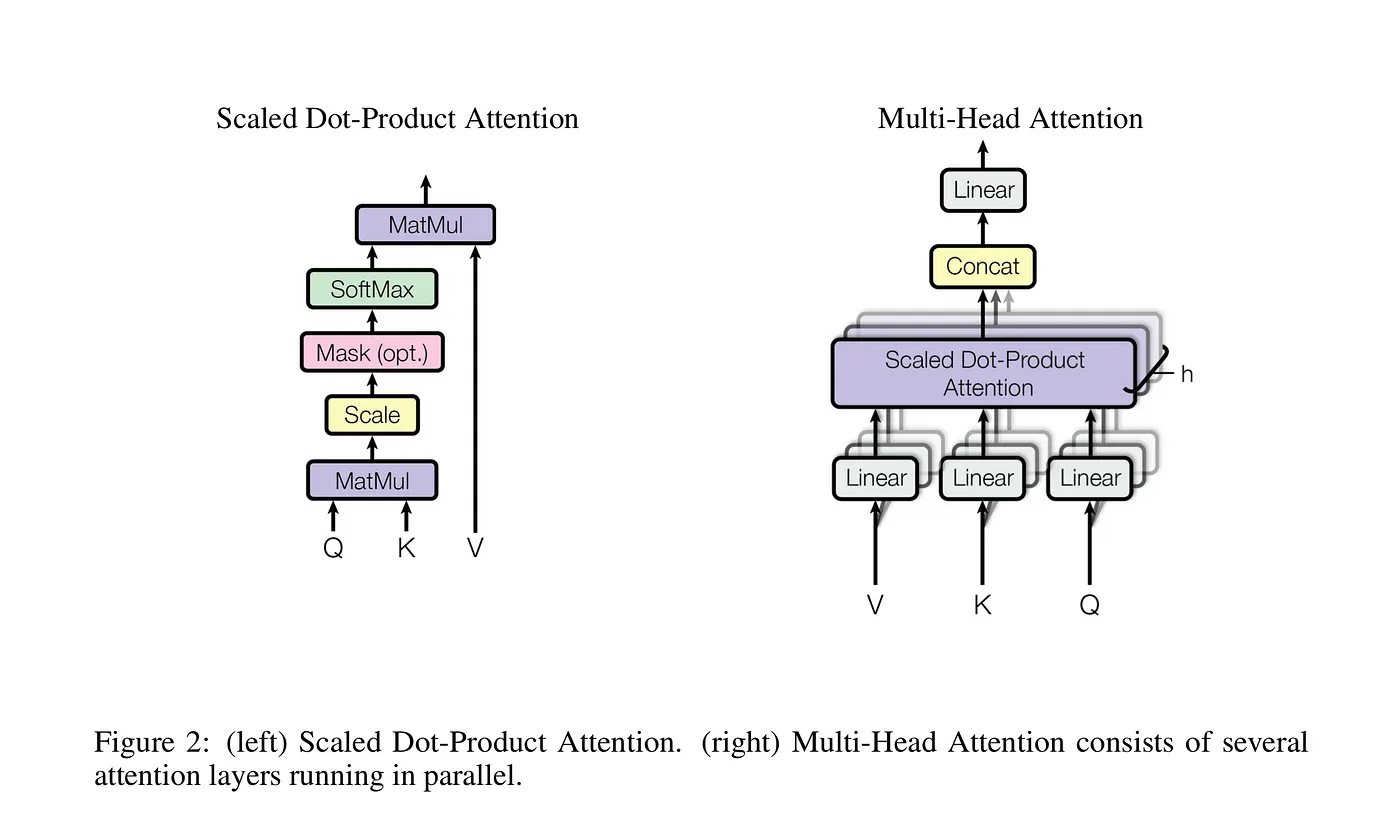

In [15]:
# class block for positional encoding

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [16]:
# class block for self attention unit

class SelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(SelfAttention, self).__init__()
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
       
        self.W_q = nn.Linear(d_model, d_model)    # torch.nn.Linear(in_features, out_features)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [17]:
# class block for feedforward

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [48]:
# class block for encoder layer

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = SelfAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [49]:
# class block for decoder layer

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = SelfAttention(d_model, num_heads)
        self.cross_attn = SelfAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [50]:
# class block for transformer layer

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)

        return output

In [51]:
# give parameters for training purpose

src_vocab_size = vocab_size_eng + 1
tgt_vocab_size = vocab_size_french + 1
d_model = 512
num_heads = 1
num_layers = 1
d_ff = 512
max_seq_length = 6
dropout = 0.2

In [ ]:
# pass all parameters to transformer class

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

In [47]:
# train the model 

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(10):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 3.495068073272705
Epoch: 2, Loss: 3.1860110759735107
Epoch: 3, Loss: 3.0611572265625
Epoch: 4, Loss: 2.873976469039917
Epoch: 5, Loss: 2.784407377243042
Epoch: 6, Loss: 2.6782991886138916
Epoch: 7, Loss: 2.4403412342071533
Epoch: 8, Loss: 2.414832592010498
Epoch: 9, Loss: 2.278183698654175
Epoch: 10, Loss: 2.147040605545044
